# Modules

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error
import yfinance as yf





# Data

In [35]:
# Get forex historical Data
df = yf.download(tickers='GOOGL',
                 period='2000d',
                 interval='1d')

df = df.drop(['High','Open','Low','Volume', 'Adj Close'], axis=1)
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.reset_index()
df.head(10)

[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2016-08-08,40.261501
1,2016-08-09,40.374001
2,2016-08-10,40.424500
3,2016-08-11,40.410000
4,2016-08-12,40.352501
5,2016-08-15,40.298000
6,2016-08-16,40.059502
7,2016-08-17,40.271000
8,2016-08-18,40.137501
9,2016-08-19,39.982498


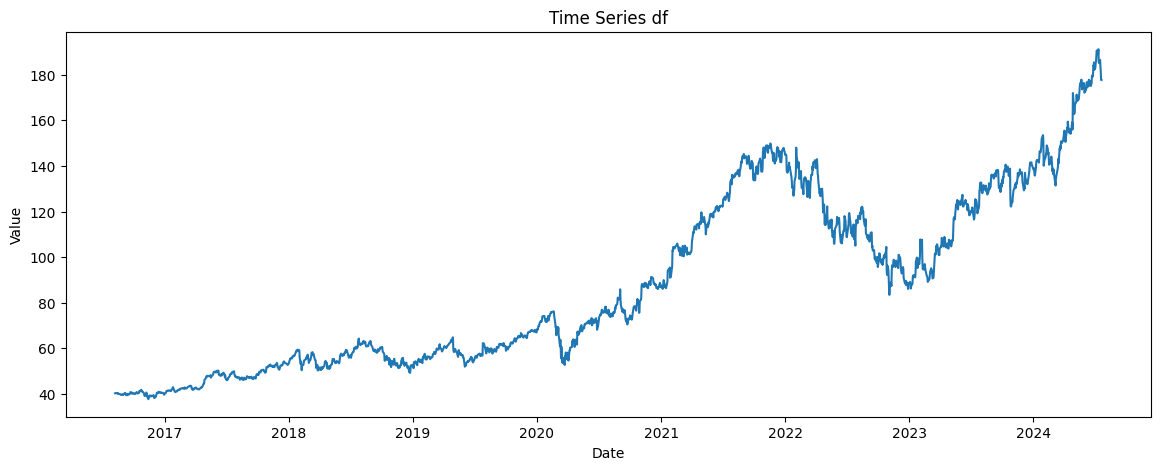

In [36]:
# Plot the time series df
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Close'])
plt.title('Time Series df')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [37]:
# Set the date column as index if it's not already
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Normalize the df
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Convert the scaled df back to a dfframe
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)
df_scaled = df_scaled.reset_index()
df_scaled

,Date,Close
0,2016-08-08,0.016939
1,2016-08-09,0.017672
2,2016-08-10,0.018001
3,2016-08-11,0.017907
4,2016-08-12,0.017532
...,...,...
1995,2024-07-15,0.969711
1996,2024-07-16,0.952709
1997,2024-07-17,0.933819
1998,2024-07-18,0.912128


In [38]:
# Split the data into training and test sets (80-20 split)
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size], df_scaled[train_size:len(df_scaled)]

# Function to create dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train["Close"].values, time_step)
X_test, y_test = create_dataset(test["Close"].values, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model

In [39]:
# GRU Model
model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=False, input_shape=(time_step, 1)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_gru.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Make predictions
train_predict_gru = model_gru.predict(X_train)
test_predict_gru = model_gru.predict(X_test)

# Invert predictions
train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)

# Calculate RMSE
rmse_gru = np.sqrt(mean_squared_error(y_test, test_predict_gru))
print(f'GRU RMSE: {rmse_gru}')


Epoch 1/50
25/25 [==============================] - 5s 45ms/step - loss: 0.0433 - val_loss: 0.0084
Epoch 2/50
25/25 [==============================] - 0s 14ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 3/50
25/25 [==============================] - 0s 18ms/step - loss: 4.3466e-04 - val_loss: 7.0254e-04
Epoch 4/50
25/25 [==============================] - 0s 17ms/step - loss: 2.8101e-04 - val_loss: 5.8461e-04
Epoch 5/50
25/25 [==============================] - 0s 19ms/step - loss: 2.5701e-04 - val_loss: 5.8905e-04
Epoch 6/50
25/25 [==============================] - 0s 17ms/step - loss: 2.4887e-04 - val_loss: 5.7455e-04
Epoch 7/50
25/25 [==============================] - 0s 16ms/step - loss: 2.4641e-04 - val_loss: 5.5179e-04
Epoch 8/50
25/25 [==============================] - 0s 15ms/step - loss: 2.3948e-04 - val_loss: 5.5687e-04
Epoch 9/50
25/25 [==============================] - 0s 18ms/step - loss: 2.3496e-04 - val_loss: 5.3895e-04
Epoch 10/50
25/25 [==============================] - 

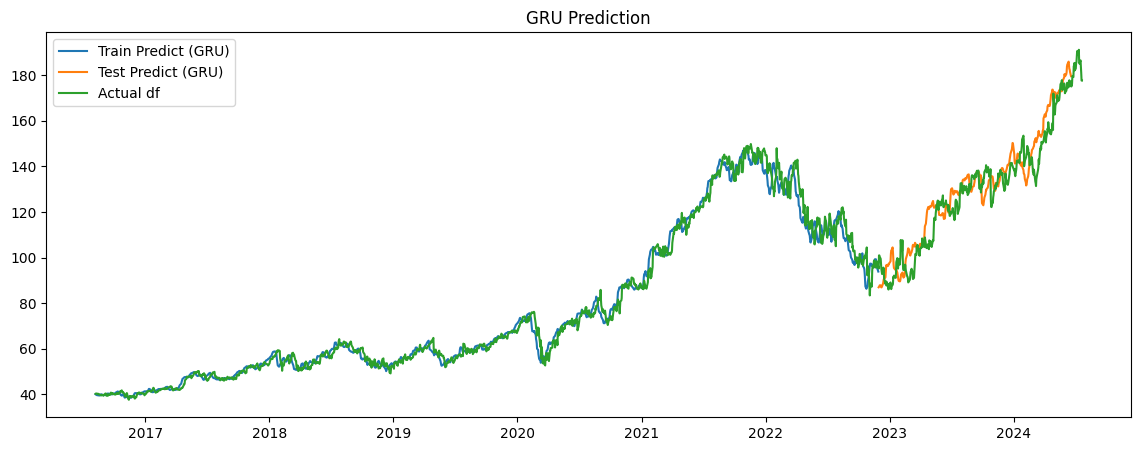

In [40]:
# Plot the results for GRU
plt.figure(figsize=(14,5))
plt.plot(df.index[:len(train_predict_gru)], train_predict_gru, label='Train Predict (GRU)')
plt.plot(df.index[len(train_predict_gru):len(train_predict_gru) + len(test_predict_gru)], test_predict_gru, label='Test Predict (GRU)')
plt.plot(df.index, df.Close, label='Actual df')
plt.title('GRU Prediction')
plt.legend()
plt.show()


In [41]:
# Predict next 30 days
future_predictions = []
last_10_days = list(test["Close"][-time_step:])

for _ in range(30):
    input_data = np.array(last_10_days[-time_step:]).reshape((1, time_step, 1))
    predicted_value = model_gru.predict(input_data)
    future_predictions.append(predicted_value[0][0])
    last_10_days.append(predicted_value[0][0])

# Invert scaling for future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(last_date, periods=30, freq='D')

# Create DataFrame for future predictions
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Future_Predictions'])


1/1 [==============================] - 0s 40ms/step


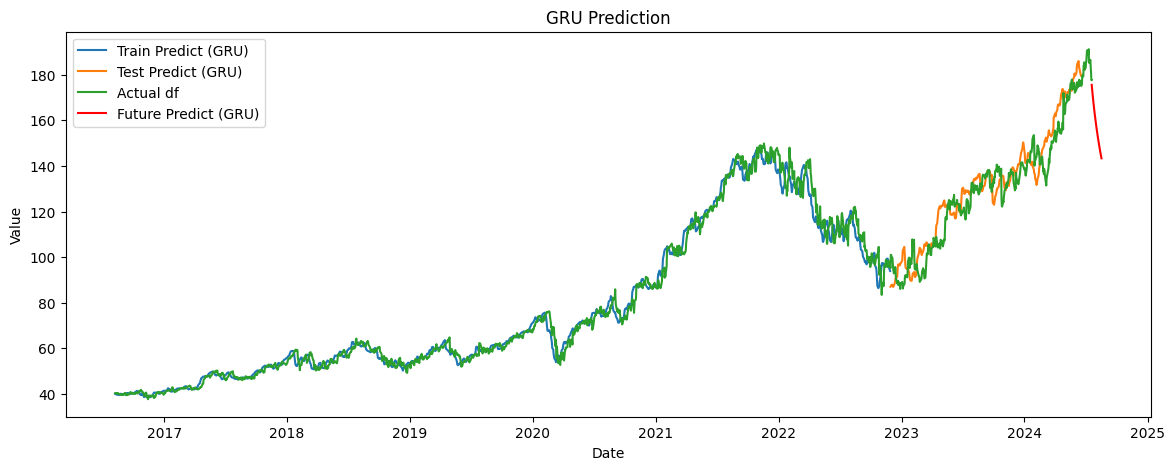

In [44]:
# Plot the results for GRU
plt.figure(figsize=(14,5))
plt.plot(df.index[:len(train_predict_gru)], train_predict_gru, label='Train Predict (GRU)')
plt.plot(df.index[len(train_predict_gru):len(train_predict_gru) + len(test_predict_gru)], test_predict_gru, label='Test Predict (GRU)')
plt.plot(df.index, df.Close, label='Actual df')
plt.plot(future_df.index, future_df['Future_Predictions'], label='Future Predict (GRU)', color='red')
plt.title('GRU Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()